In [121]:
import pandas as pd
import random
import ast
import numpy as np
import scipy.stats as stats 
from scipy.spatial import distance
import statsmodels.stats.multitest as multitest

import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go
import os, glob
import pickle
import itertools
import concurrent.futures
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
import statsmodels.api as sm
from stargazer.stargazer import Stargazer, LineLocation
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from copy import deepcopy
from ax import optimize
from ax.plot.contour import plot_contour
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.plot.trace import optimization_trace_single_method

from concurrent_functions import get_q2_concurrent, calculate_q2_for_combination
plt.rcParams["font.family"] = "Times New Roman"

import torch
mps_device = torch.device("mps")

# What if we looked at every observation, rather than grouping by instance characteristics?

In [2]:
# change current working directory to the base
os.chdir('../')
os.getcwd()

'/Users/xehu/Desktop/Team Process Mapping/tpm-horse-race-modeling'

In [3]:
# full_multi_task_data = pd.read_csv('./task_map_explorations_with_multitask/wave_1_raw_score_data.csv')

In [4]:
full_multi_task_data = pd.read_csv('./task_map_explorations_with_multitask/all_multi_task_wave_data.txt')

In [5]:
full_multi_task_data = full_multi_task_data.rename(columns = {"task": "task_name"})

In [6]:
# set the score to the best score across repeated attempts, in cases where it saved multiple times
full_multi_task_data = full_multi_task_data.groupby('stageId').apply(lambda x: x.loc[x['score'].idxmax()]).reset_index(drop=True)

In [7]:
# here's the full list of tasks!
set(full_multi_task_data["task_name"])

{'Advertisement Writing',
 'Allocating Resources',
 'Divergent Association',
 'Guess the Correlation',
 'Logic Problem',
 'Moral Reasoning',
 'Putting Food Into Categories',
 'Random Dot Motion',
 'Recall Association',
 'Recall Word Lists',
 'Room Assignment',
 'Sudoku',
 'Typing',
 'Unscramble Words',
 'Whac a Mole',
 'WildCam',
 'Wildcat Wells',
 'Wolf Goat Cabbage',
 'Word Construction',
 'Writing Story'}

In [8]:
# task map
task_map = pd.read_csv('./features/task-mapping/task_map.csv')
task_map = task_map.rename(columns = {"task": "task_name"})

In [9]:
task_name_mapping = {
    "Sudoku": "Sudoku",
    "Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
    "Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
    "Guess the Correlation": "Guessing the correlation",
    "Writing Story": "Writing story",
    "Room Assignment": "Room assignment task",
    "Allocating Resources": "Allocating resources to programs",
    "Divergent Association": "Divergent Association Task",
    "Word Construction": "Word construction from a subset of letters",
    "Whac a Mole": "Whac-A-Mole",
    "Random Dot Motion": "Random dot motion",
    "Recall Association": "Recall association",
    "Recall Word Lists": "Recall word lists",
    "Typing": "Typing game",
    "Unscramble Words": "Unscramble words (anagrams)",
    "WildCam": "Wildcam Gorongosa (Zooniverse)",
    "Advertisement Writing": "Advertisement writing",
    "Putting Food Into Categories": "Putting food into categories"
}

In [10]:
task_map.columns

Index(['task_name', 'Q1concept_behav', 'Q3type_1_planning',
       'Q4type_2_generate', 'Q6type_5_cc', 'Q7type_7_battle',
       'Q8type_8_performance', 'Q9divisible_unitary', 'Q10maximizing',
       'Q11optimizing', 'Q13outcome_multip', 'Q14sol_scheme_mul',
       'Q15dec_verifiability', 'Q16shared_knowledge', 'Q17within_sys_sol',
       'Q18ans_recog', 'Q19time_solvability', 'Q20type_3_type_4',
       'Q22confl_tradeoffs', 'Q23ss_out_uncert', 'Q24eureka_question',
       'Q2intel_manip_1', 'Q21intellective_judg_1', 'Q5creativity_input_1',
       'Q25_type6_mixed_motive'],
      dtype='object')

In [11]:
task_map = task_map.rename(
    columns = {
        "Q1concept_behav": "Conceptual-Behavioral",
        "Q3type_1_planning": "Type 1 (Planning)",
        "Q4type_2_generate": "Type 2 (Generate)",
        "Q6type_5_cc": "Type 5 (Cognitive Conflict)",
        "Q7type_7_battle": "Type 7 (Battle)",
        "Q8type_8_performance": "Type 8 (Performance)",
        "Q9divisible_unitary": "Divisible-Unitary",
        "Q10maximizing": "Maximizing",
        "Q11optimizing": "Optimizing",
        "Q13outcome_multip": "Outcome Multiplicity",
        "Q14sol_scheme_mul": "Solution Scheme Multiplicity",
        "Q15dec_verifiability": "Decision Verifiability",
        "Q16shared_knowledge": "Shared Knowledge",
        "Q17within_sys_sol": "Within-System Solution",
        "Q18ans_recog": "Answer Recognizability",
        "Q19time_solvability": "Time Solvability",
        "Q20type_3_type_4": "Type 3 and Type 4 (Objective Correctness)",
        "Q22confl_tradeoffs": "Conflicting Tradeoffs",
        "Q23ss_out_uncert": "Solution Scheme Outcome Uncertainty",
        "Q24eureka_question": "Eureka Question",
        "Q2intel_manip_1" : "Intellectual-Manipulative",
        "Q21intellective_judg_1" : "Intellective-Judgmental",
        "Q5creativity_input_1" : "Creativity Input",
        "Q25_type6_mixed_motive" : "Type 6 (Mixed-Motive)"
    }
)

In [12]:
# make the names match
full_multi_task_data.loc[:, "task_name"] = full_multi_task_data["task_name"].replace(task_name_mapping)

In [13]:
# merge in the task features
full_multi_task_data = pd.merge(left = full_multi_task_data, right = task_map, on = "task_name", how = "left")

# create dummies for complexity (commented out because this is already done in the latest data dump)
# complexity_columns = ["High", "Low", "Medium"]
# full_multi_task_data = pd.get_dummies(full_multi_task_data, columns = ["complexity"]).rename(columns = {"complexity_High": "High", "complexity_Low": "Low", "complexity_Medium": "Medium"})
# full_multi_task_data[complexity_columns] = full_multi_task_data[complexity_columns].astype(int)

### Exploring different subset of 10 tasks!

In [14]:
# we have 20 tasks in total
len(full_multi_task_data["task_name"].unique())

20

In [15]:
def greedy_maximin(data, remaining, selected,  n, metric="euclidean"):
    """
        data: pandas dataframe(rows=points, cols=dimensions)
            points to choose from
            
        remaining: indexes of `data` that are candidates for the next point
        
        selected: indexes of `data` that have already been included
        
        n: number of additional points to include
        
        metric: "euclidean" "cityblock"
            distance measures from scipy.spatial.distance
    """
    distances = []
    for _ in range(n):
        dists = distance.cdist(data.loc[selected], data.loc[remaining], metric)
        closest = dists.min(axis=0)  # distance between candidates and closest selection
        distances.append(closest.max())
        add = remaining[np.argmax(closest)]
        selected += [add]
        remaining.remove(add)

    return selected, distances

In [16]:
def within_set_distance(data, selected, metric="euclidean"):
    return distance.cdist(data.loc[selected],data.loc[selected], metric) 

In [17]:
# these are valid predictors
task_cols_to_use = task_map.drop(["task_name", "Type 6 (Mixed-Motive)"], axis = 1).columns

In [18]:
# set up mini task map of just the ones we have
sub_task_map = full_multi_task_data[["task_name"] + list(task_cols_to_use)].drop_duplicates().reset_index(drop=True)
# set rownames of sub_task_map to be the column "task_name"
sub_task_map.index = sub_task_map["task_name"]
sub_task_map = sub_task_map.drop("task_name", axis = 1)

In [19]:
scores_dict = {}
for task in sub_task_map.index:
    selected = [task]
    remaining = list(sub_task_map.index.difference(selected))
    choices,scores = greedy_maximin(sub_task_map, remaining, selected, n=10)
    scores_dict[task] = scores[9]

In [20]:
selected = [pd.Series(scores_dict).idxmax()]
remaining = list(sub_task_map.index.difference(selected))
choices,scores = greedy_maximin(sub_task_map, remaining, selected, n=9) # needs to be 9 because we already selected 1
choices

['Unscramble words (anagrams)',
 'Moral Reasoning (Disciplinary Action Case)',
 'Putting food into categories',
 'Whac-A-Mole',
 'Wolf, goat and cabbage transfer',
 'Room assignment task',
 'Sudoku',
 'Writing story',
 'Word construction from a subset of letters',
 'Divergent Association Task']

In [21]:
# the set of 10 tasks (within the possible set of 20) that is "furthest apart"
# FILTER TASK DATA DOWN TO THIS (task in choices)
selected_multi_task_data = full_multi_task_data[full_multi_task_data["task_name"].isin(choices)]

# Add Compositional Features

In [22]:
players_per_stage = selected_multi_task_data[["stageId", "playerIds"]]

In [23]:
players_per_stage

,stageId,playerIds
0,2279a3gi8ERfCfusv,"8igh8oQgHuyAyK4pc,Ncjc8SACqKJyDu4ii,mFQycYNpCQ..."
2,22bJZWfgB3gfKXY6A,"4gSpwy2zhj5TqoZH6,HxHGyhNNY2hLwBQq8,NGyb7W89HC..."
3,22wFrSqgf8ESM8pNY,"8KkPHg2uioctf3Rbs,F7RyzbL5Nk2aXrXpA,KwAN4ic6PA..."
9,24uBQrHu4jKFgGQ24,SWY4y537pm3vP9BCF
11,26RnwcdY842ZGSQtT,"A9GsS4XvyujhjaRw5,GncukxCZHcNhuWePC,SZmiBQDByx..."
...,...,...
5960,zw2fcJ8qbMcz6LEPw,"9GQzFn34xGisJepJe,A32bectX3aPEK4Pca,Jr8QZZvEgX..."
5962,zx7ed3AgYwivSKFtY,MN5S7gh2WFrvn7cRb
5963,zyhzfk8duc4Kc4uXH,"9ammsNRNKN4ws9kcg,iAJbWpWs6Xjqeij9S,vZ9zKXjDLL..."
5964,zyuSozjmYFvQjgY9J,jwpXJTe8TKDMeW8zb


In [24]:
# This is the list of people who played
players_1 = pd.read_csv('./task_map_explorations_with_multitask/players_wave1_epoch1.csv')
players_2 = pd.read_csv('./task_map_explorations_with_multitask/players_wave1_epoch2.csv')
players_wave2 = pd.read_csv('./task_map_explorations_with_multitask/players_wave_2.csv')
players_wave3 = pd.read_csv('./task_map_explorations_with_multitask/players_wave_3.csv')

players = pd.concat([players_1, players_2, players_wave2, players_wave3])

In [25]:
player_workerIds = players[["_id", "id"]].dropna().rename(columns = {"_id": "playerId", "id": "WorkerId"})
# parse out the first part of WorkerId
player_workerIds["WorkerId"] = player_workerIds["WorkerId"].str.split(" ").str[0]

In [26]:
# match playerIds to players_per_stage based on whether data.playerIds CONTAINS the playerId
stage_id_to_player_and_worker = pd.DataFrame(columns=["stageId", "playerId", "WorkerId"])

# Use tqdm to create a progress bar for the loop
for player in tqdm(player_workerIds["playerId"], desc="Matching playerIds"):
    stages_played = players_per_stage[players_per_stage["playerIds"].str.contains(player)].copy()

    if len(stages_played) > 0:
        # Set "playerId" column to the player's id
        stages_played["playerId"] = player
        # Get workerId of player
        workerId = player_workerIds.loc[player_workerIds["playerId"] == player, "WorkerId"].values[0]
        # Set "WorkerId" column to the player's id
        stages_played["WorkerId"] = workerId
        new_player_rows = stages_played[["stageId", "playerId", "WorkerId"]]
        stage_id_to_player_and_worker = pd.concat([stage_id_to_player_and_worker, new_player_rows], axis=0)

Matching playerIds: 100%|██████████| 2839/2839 [00:02<00:00, 1372.42it/s]


In [27]:
# heres the information we have about all the workers
# generate a link here: https://github.com/Watts-Lab/panel/blob/main/clean_data/individuals.csv
panel = pd.read_csv('https://raw.githubusercontent.com/Watts-Lab/panel/main/clean_data/individuals.csv?token=GHSAT0AAAAAACNTSY6HNN3TYZSOOAEL5TGQZSGXM6A')

In [28]:
panel_filtered = panel[["WorkerId", "CRT", "RME"]]

In [29]:
individual_workers_by_stageId = pd.merge(left = stage_id_to_player_and_worker, right = panel_filtered, on = "WorkerId", how = "left")
composition_by_stageId = individual_workers_by_stageId[["stageId", "CRT", "RME"]].groupby("stageId").mean().reset_index()


In [30]:
# Design decision: Drop cases where we don't have information on the participants.
# many of these are actually test datapoints (e.g., Mark and Eric)
print("Dropping " + str(len(composition_by_stageId) - len(composition_by_stageId.dropna())) + " rows.")
composition_by_stageId = composition_by_stageId.dropna()

Dropping 97 rows.


# Filter to only Teams

In [31]:
team_multi_task_data = selected_multi_task_data[selected_multi_task_data["playerCount"]>1]
individual_multi_task_data = selected_multi_task_data[selected_multi_task_data["playerCount"]==1]

In [32]:
# number of teams per task!
team_multi_task_data["task_name"].value_counts()

task_name
Wolf, goat and cabbage transfer               201
Whac-A-Mole                                   193
Room assignment task                          186
Putting food into categories                  182
Moral Reasoning (Disciplinary Action Case)    174
Writing story                                 172
Word construction from a subset of letters    172
Sudoku                                        168
Unscramble words (anagrams)                   162
Divergent Association Task                    152
Name: count, dtype: int64

In [33]:
team_composition_by_stageId = composition_by_stageId[composition_by_stageId['stageId'].isin(team_multi_task_data['stageId'])]

In [34]:
team_composition_by_stageId

,stageId,CRT,RME
0,2279a3gi8ERfCfusv,0.626984,29.666667
1,22bJZWfgB3gfKXY6A,0.714286,28.833333
2,22wFrSqgf8ESM8pNY,0.849206,26.000000
4,26RnwcdY842ZGSQtT,0.468254,28.000000
8,2BFbe8Tut5QLrTks9,0.396825,24.333333
...,...,...,...
3109,zjhgGd8DuM5Qxu92X,0.619048,24.666667
3110,zouciAtkfHj9FkpNa,0.476190,21.666667
3113,zq4k4kqAGjYMJ4nP2,0.734127,31.333333
3119,zw2fcJ8qbMcz6LEPw,0.380952,26.333333


In [35]:
players_on_teams = individual_workers_by_stageId[individual_workers_by_stageId['stageId'].isin(team_composition_by_stageId['stageId'])]

In [36]:
# get the total number of task instances we had access to
# note that due to the task filtering, we're getting on average 7 instances per team
team_multi_task_data[["playerIds", "stageId"]].groupby("playerIds").nunique().describe()

,stageId
count,240.000000
mean,7.341667
std,4.711769
min,1.000000
25%,3.000000
50%,5.000000
75%,12.000000
max,15.000000


In [37]:
# how many teams of each type?
team_multi_task_data[["playerIds", "playerCount"]].groupby("playerIds").first().reset_index()["playerCount"].value_counts()

playerCount
3    134
6    106
Name: count, dtype: int64

In [38]:
# get the total number of players we had access to
len(players_on_teams["playerId"].unique())

1023

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



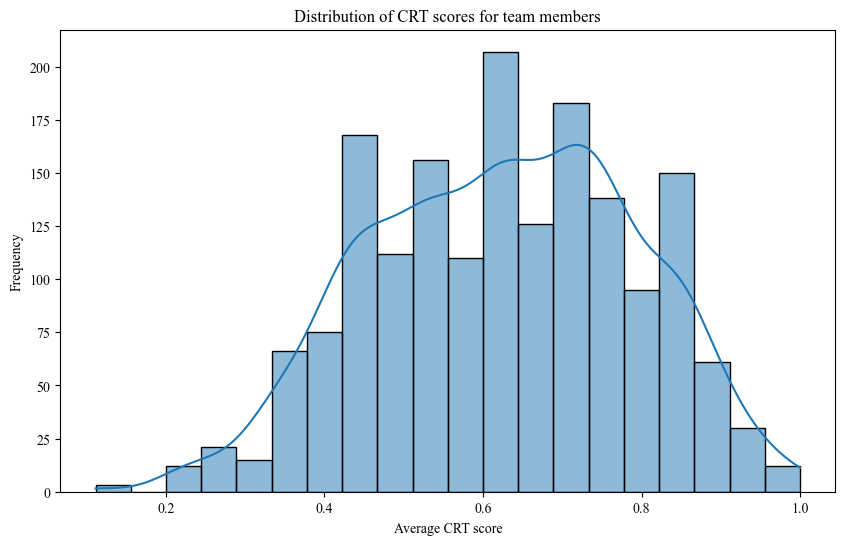

In [39]:
# plot the CRT histogram distribution of team_composition_by_stageId["CRT"]
plt.figure(figsize=(10, 6))
sns.histplot(team_composition_by_stageId["CRT"], bins=20, kde=True)
plt.title("Distribution of CRT scores for team members")
plt.xlabel("Average CRT score")
plt.ylabel("Frequency")
plt.show()

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



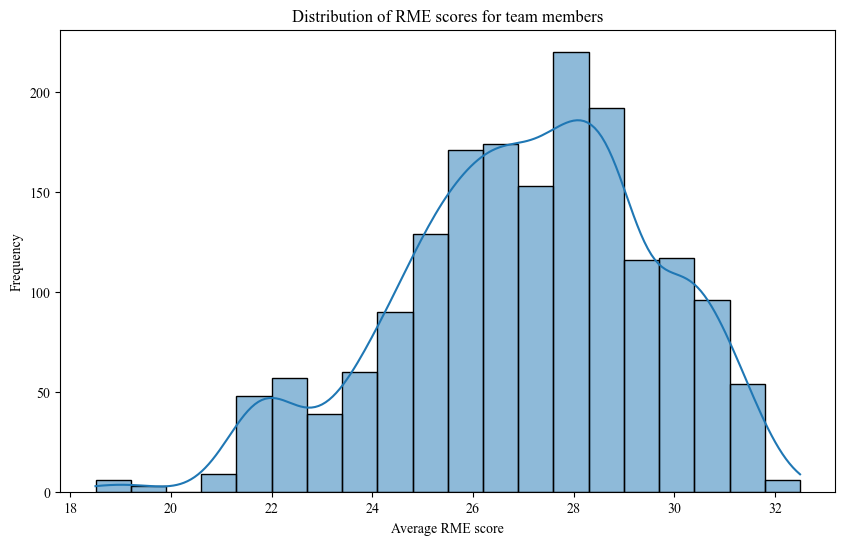

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(team_composition_by_stageId["RME"], bins=20, kde=True)
plt.title("Distribution of RME scores for team members")
plt.xlabel("Average RME score")
plt.ylabel("Frequency")
plt.show()

In [41]:
# add in RME and CRT to the team multi-task data
team_multi_task_data = team_multi_task_data.merge(team_composition_by_stageId, on = "stageId", how = "inner")

# Exploratory linear regressions

Three outcome variables:
1. **Score**: Normalized such that the highest scoring team gets 100
2. **Duration**: Amount of time spent completing the task (in minutes)
3. **Efficiency**: Score / Duration

In [42]:
def feature_downselect_with_lasso(cols):
    lassocv = LassoCV(cv=10, random_state=0, max_iter=100000).fit(team_multi_task_data[cols], team_multi_task_data["score"])
    best_alpha = lassocv.alpha_
    fitted_lasso_model = Lasso(alpha = best_alpha, max_iter=100000).fit(team_multi_task_data[cols], team_multi_task_data["score"])

    lasso_feature_names = fitted_lasso_model.feature_names_in_
    lasso_coefs = fitted_lasso_model.coef_

    lasso_weights = pd.DataFrame(
        {"features": lasso_feature_names,
        "LASSO_weight": lasso_coefs}
    )

    # filter for LASSO_weight != 0
    return lasso_weights[lasso_weights['LASSO_weight'] != 0]["features"]

In [43]:
nonzero_lasso_weights_task = feature_downselect_with_lasso(list(task_cols_to_use))

In [44]:
# Set coefficients to use
"""
We want:
- Task Features
- Team Size
- CRT and RME Score

Version 1: Let's Intersect them all against each other
"""
for task_col in nonzero_lasso_weights_task:
    # intersect with team size
    task_col_x_teamsize = team_multi_task_data[task_col]*team_multi_task_data["playerCount"]
    team_multi_task_data.loc[:, task_col + " x playerCount"] = task_col_x_teamsize

    # intersect with CRT
    task_col_x_CRT = team_multi_task_data[task_col]*team_multi_task_data["CRT"]
    team_multi_task_data.loc[:, task_col + " x CRT"] = task_col_x_CRT

    # intersect with RME
    task_col_x_RME = team_multi_task_data[task_col]*team_multi_task_data["RME"]
    team_multi_task_data.loc[:, task_col + " x RME"] = task_col_x_RME

In [49]:
task_cols_and_derivatives = list(task_cols_to_use) + [col for col in team_multi_task_data.columns if "x" in col]
# get a unique list
task_cols_and_derivatives = list(set(task_cols_and_derivatives))

In [50]:
all_features_and_interactions = task_cols_and_derivatives + ["CRT", "RME", "playerCount"] + ["High", "Medium"]

In [51]:
RME_and_interactions = [col for col in all_features_and_interactions if "RME" in col]
CRT_and_interactions = [col for col in all_features_and_interactions if "CRT" in col]
playerCount_and_interactions = [col for col in all_features_and_interactions if "playerCount" in col]

In [52]:
# nonzero_lasso_weights_RME = feature_downselect_with_lasso(RME_and_interactions)
# nonzero_lasso_weights_CRT = feature_downselect_with_lasso(CRT_and_interactions)
# nonzero_lasso_weights_playerCount = feature_downselect_with_lasso(playerCount_and_interactions)

In [53]:
controls = ["High", "Medium"]

In [54]:
# Design decision --- standardize iv (standardize task features, RME, CRT, and any interaction terms involving task features)
team_multi_task_data = team_multi_task_data.copy()
team_multi_task_data[task_cols_and_derivatives + ["CRT", "RME"]] = StandardScaler().fit_transform(team_multi_task_data[task_cols_and_derivatives + ["CRT", "RME"]])

In [55]:
task_crt_lm = sm.OLS(endog = team_multi_task_data["score"], exog=sm.add_constant(team_multi_task_data[list(nonzero_lasso_weights_task) + CRT_and_interactions + controls])).fit()
task_rme_lm = sm.OLS(endog = team_multi_task_data["score"], exog=sm.add_constant(team_multi_task_data[list(nonzero_lasso_weights_task) + RME_and_interactions + controls])).fit()
task_playercount_lm = sm.OLS(endog = team_multi_task_data["score"], exog=sm.add_constant(team_multi_task_data[list(nonzero_lasso_weights_task) + playerCount_and_interactions + controls])).fit()

models = [task_crt_lm, task_rme_lm, task_playercount_lm]
stargazer = Stargazer(models)

## LRT of interaction on top of main effect

In [276]:
task_lm = sm.OLS(endog = team_multi_task_data["score"], exog=sm.add_constant(team_multi_task_data[list(nonzero_lasso_weights_task) + controls])).fit()

In [281]:
lr_statistic, p_value, df = task_crt_lm.compare_lr_test(task_lm)
print("Likelihood Ratio Statistic") # The likelihood ratio which is chisquare distributed with df_diff degrees of freedom.
print(lr_statistic)
print("p-value")
print(p_value)

Likelihood Ratio Statistic
48.56056353092936
p-value
4.902354897696812e-07


In [282]:
lr_statistic, p_value, df = task_rme_lm.compare_lr_test(task_lm)
print("Likelihood Ratio Statistic") # The likelihood ratio which is chisquare distributed with df_diff degrees of freedom.
print(lr_statistic)
print("p-value")
print(p_value)

Likelihood Ratio Statistic
15.595928004582674
p-value
0.1117984697942614


In [283]:
lr_statistic, p_value, df = task_playercount_lm.compare_lr_test(task_lm)
print("Likelihood Ratio Statistic") # The likelihood ratio which is chisquare distributed with df_diff degrees of freedom.
print(lr_statistic)
print("p-value")
print(p_value)

Likelihood Ratio Statistic
144.6386936682793
p-value
4.712628887409452e-26


## Correct all p-values and Standard Errors for Multiple Comparisons

In [250]:
# Extract p-values from the models
p_values = [task_crt_lm.pvalues, task_rme_lm.pvalues, task_playercount_lm.pvalues]

# Flatten the list of p-values
all_p_values = [p for sublist in p_values for p in sublist]

# Apply Benjamini-Hochberg correction
rejected, corrected_p_values, _, _ = multitest.multipletests(all_p_values, alpha=0.05, method='fdr_bh')

# Map the corrected p-values back to the original p-values structure
corrected_p_values_task_crt = pd.Series(corrected_p_values[:len(task_crt_lm.pvalues)], index = task_crt_lm.pvalues.index)
corrected_p_values_task_rme = pd.Series(corrected_p_values[len(task_crt_lm.pvalues):len(task_crt_lm.pvalues)+len(task_rme_lm.pvalues)], index = task_rme_lm.pvalues.index)
corrected_p_values_task_playercount = pd.Series(corrected_p_values[len(task_crt_lm.pvalues)+len(task_rme_lm.pvalues):], index = task_playercount_lm.pvalues.index)

# Corrected p-values
task_crt_lm.pvalues_corrected = corrected_p_values_task_crt
task_rme_lm.pvalues_corrected = corrected_p_values_task_rme
task_playercount_lm.pvalues_corrected = corrected_p_values_task_playercount

# Corrected standard errors
corrected_t_values_task_crt = stats.norm.ppf(1 - corrected_p_values_task_crt / 2) * np.sign(task_crt_lm.tvalues)
corrected_t_values_task_rme = stats.norm.ppf(1 - corrected_p_values_task_rme / 2) * np.sign(task_rme_lm.tvalues)
corrected_t_values_task_playercount = stats.norm.ppf(1 - corrected_p_values_task_playercount / 2) * np.sign(task_playercount_lm.tvalues)

corrected_se_task_crt = task_crt_lm.params / corrected_t_values_task_crt
corrected_se_task_rme = task_rme_lm.params / corrected_t_values_task_rme
corrected_se_task_playercount = task_playercount_lm.params / corrected_t_values_task_playercount

task_crt_lm.bse_corrected = corrected_se_task_crt
task_rme_lm.bse_corrected = corrected_se_task_rme
task_playercount_lm.bse_corrected = corrected_se_task_playercount


In [231]:
# stargazer

## Separating Task Effects

In [147]:
def intensify_color(color, factor=0.5):
    """ Make the color more intense by scaling the RGB values. """
    color_rgb = mcolors.to_rgb(color)
    return tuple(min(1, c * factor) for c in color_rgb)

In [271]:
def plot_models(models, features_to_plot, model_names, colors, title, figsize = (8, 10), pval_thresh = 0.05):
    # Create a DataFrame to organize the parameters for easier manipulation
    pvalues_corrected_df = pd.DataFrame([model.pvalues_corrected for model in models], index=model_names).filter(features_to_plot)
    params_df = pd.DataFrame([model.params for model in models], index=model_names).filter(features_to_plot)

    sorted_columns = params_df.sum().sort_values(ascending=False).index

    # order everything by smallest to largest effect size
    params_df = params_df.reindex(columns=sorted_columns)
    pvalues_corrected_df = pvalues_corrected_df.reindex(columns=sorted_columns)
    stderr_df = pd.DataFrame([model.bse for model in models], index=model_names).reindex(columns=sorted_columns)
    stderr_corrected_df = pd.DataFrame([model.bse_corrected for model in models], index=model_names).reindex(columns=sorted_columns)

    fig, ax = plt.subplots(figsize=figsize)
    y_positions = np.arange(len(params_df.columns)) * 10 # spread out y-positions

    #### THIS PLOTS THE REGULAR THING ###
    for i, model_name in enumerate(model_names):
        pvalues_corrected = pvalues_corrected_df.loc[model_name]
        means = params_df.loc[model_name]
        errors = stderr_df.loc[model_name]
        errors_corrected = stderr_corrected_df.loc[model_name]

        plot_color = colors[i]

        # Plot corrected errors with colored solid lines
        ax.errorbar(means, y_positions + i * 0.2, xerr=errors_corrected, fmt='o', color=plot_color, capsize=3, label=f'{model_name} (SE Corrected)')

        # Plot uncorrected errors with gray broken lines
        ax.errorbar(means, y_positions + i * 0.2, xerr=errors, fmt='none', color=intensify_color(plot_color, factor=0.7), capsize=1, label=f'{model_name} (SE Uncorrected)')

    ### THIS GRAYS OUT THE NON-SIGNIFICANT ONES ###
    for i, model_name in enumerate(model_names):
        pvalues_corrected = pvalues_corrected_df.loc[model_name]
        means = params_df.loc[model_name]
        errors = stderr_df.loc[model_name]
        errors_corrected = stderr_corrected_df.loc[model_name]

        # Iterate over each point and plot it with its corresponding color based on p-value significance
        for j, (mean, error, error_corrected, pval) in enumerate(zip(means, errors, errors_corrected, pvalues_corrected)):
            plot_color = colors[i] if pval <= pval_thresh else 'lightgray'
            # Plot corrected errors with colored solid lines
            ax.errorbar(mean, y_positions[j] + i * 0.2, xerr=error_corrected, fmt='o', color=plot_color, capsize=3)
            # Plot uncorrected errors with gray broken lines
            ax.errorbar(mean, y_positions[j] + i * 0.2, xerr=error, fmt='none', color=intensify_color(plot_color, factor=0.7), capsize=1)
       
    ax.set_title(title)
    ax.set_xlabel('Coefficient Value') 
    ax.set_ylabel('Variables')  
    ax.set_yticks(y_positions + (len(models) - 1) * 0.2 / 2)  
    ax.set_yticklabels(params_df.columns, rotation=45, ha="right")  
    ax.grid(axis='x', linestyle='--', alpha=0.7)  
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.axvline(x=0, color='r', linestyle='-') 
    plt.show()

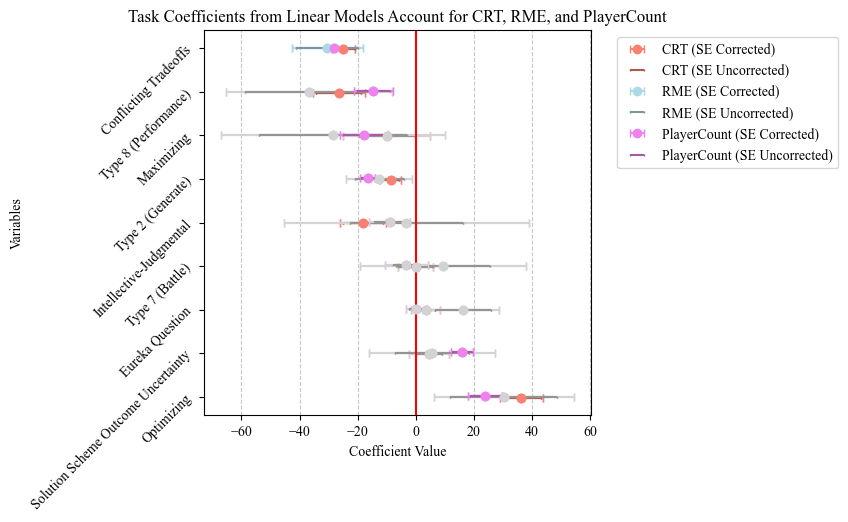

In [272]:
plot_models(models, features_to_plot=nonzero_lasso_weights_task, model_names=["CRT", "RME", "PlayerCount"], colors=['salmon', 'lightblue', 'violet'], title='Task Coefficients from Linear Models Account for CRT, RME, and PlayerCount', figsize = (5, 5))

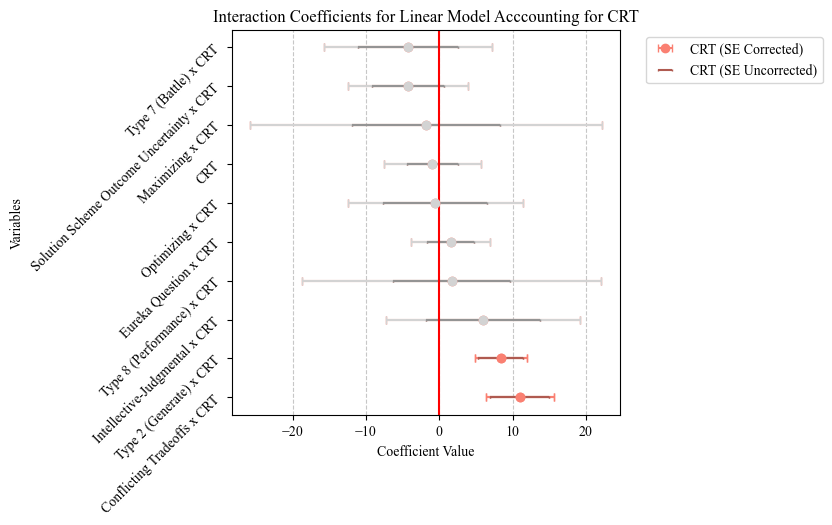

In [273]:
plot_models([task_crt_lm], features_to_plot=CRT_and_interactions, model_names=["CRT"], colors=['salmon'], title='Interaction Coefficients for Linear Model Acccounting for CRT', figsize = (5, 5))

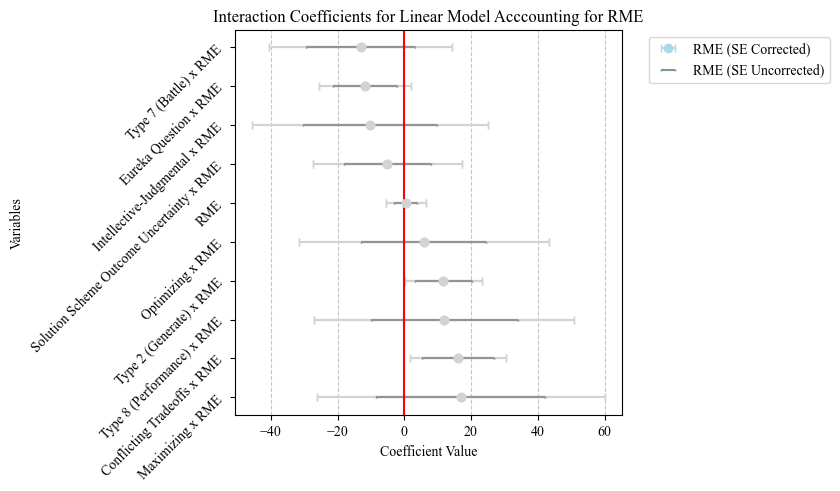

In [274]:
plot_models([task_rme_lm], features_to_plot=RME_and_interactions, model_names=["RME"], colors=['lightblue'], title='Interaction Coefficients for Linear Model Acccounting for RME', figsize = (5, 5))

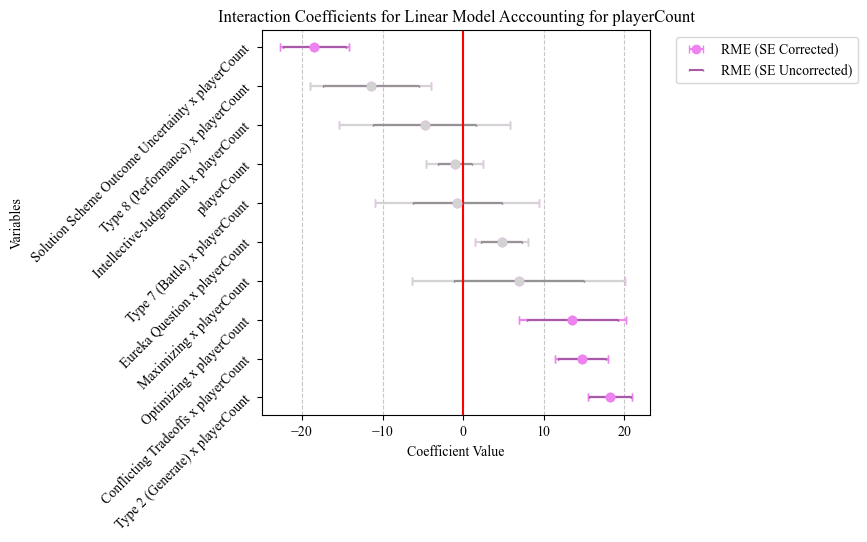

In [275]:
plot_models([task_playercount_lm], features_to_plot=playerCount_and_interactions, model_names=["RME"], colors=['violet'], title='Interaction Coefficients for Linear Model Acccounting for playerCount', figsize = (5, 5))

# Adding back Communication Features

Commenting out communication features because we don't have comms data for waves 2 and 3 yet!

In [67]:
# # # add in some communication features
# with open("./data_cache/multi_task_stageId_noncumulative_nonstandardized.pkl", "rb") as cleaned_pickle_file:
# 	stage_based_data = pickle.load(cleaned_pickle_file)
	
# comms_features = stage_based_data.data[["stageId", "gini_coefficient_sum_num_messages", "sum_num_words", "average_positive_bert"]]

In [68]:
# team_multi_task_data_conv = pd.merge(comms_features, team_multi_task_data, on = "stageId", how = "inner")

In [69]:
# # z-score "gini_coefficient_sum_num_messages", "sum_num_words", "average_positive_bert" to put them on the same scale
# team_multi_task_data_conv[["gini_coefficient_sum_num_messages", "sum_num_words", "average_positive_bert"]] = StandardScaler().fit_transform(team_multi_task_data_conv[["gini_coefficient_sum_num_messages", "sum_num_words", "average_positive_bert"]])

In [70]:
# gini_lm = sm.OLS(endog = team_multi_task_data_conv["gini_coefficient_sum_num_messages"], exog=sm.add_constant(team_multi_task_data_conv[all_features_and_interactions])).fit()
# total_words_lm = sm.OLS(endog = team_multi_task_data_conv["sum_num_words"], exog=sm.add_constant(team_multi_task_data_conv[all_features_and_interactions])).fit()
# positivity_lm = sm.OLS(endog = team_multi_task_data_conv["average_positive_bert"], exog=sm.add_constant(team_multi_task_data_conv[all_features_and_interactions])).fit()

# conv_models = [gini_lm, total_words_lm, positivity_lm]
# stargazer = Stargazer(conv_models)

In [71]:
# stargazer

In [72]:
# model_names = ["Gini Coefficient", "Total Number of Words", "Average Message Positivity"]
# colors = ['salmon', 'lightblue', 'violet']

# # Create a DataFrame to organize the parameters for easier manipulation
# params_df = pd.DataFrame([model.params for model in conv_models], index=model_names)
# sorted_columns = params_df.sum().sort_values(ascending=False).index
# # order everything by smallest to largest effect size
# params_df = params_df.reindex(columns=sorted_columns)
# stderr_df = pd.DataFrame([model.bse for model in conv_models], index=model_names).reindex(columns=sorted_columns)

# fig, ax = plt.subplots(figsize=(8, 30))
# y_positions = np.arange(len(params_df.columns)) * 10 # spread out y-positions

# for i, model_name in enumerate(model_names):
#     means = params_df.loc[model_name]
#     errors = stderr_df.loc[model_name]

#     plt.errorbar(means, y_positions + i * 0.2, xerr=errors, fmt='o', label=f'{model_name}', color=colors[i], capsize=1)

# ax.set_title('Effect of Features on Communication Attributes')
# ax.set_xlabel('Coefficient Value') 
# ax.set_ylabel('Variables')  
# ax.set_yticks(y_positions + (len(conv_models) - 1) * 0.2 / 2)  
# ax.set_yticklabels(params_df.columns, rotation=45, ha="right")  
# ax.grid(axis='x', linestyle='--', alpha=0.7)  
# ax.legend()

# plt.axvline(x=0, color='r', linestyle='-') 
# plt.show()

## Recreation of PCA Plot (Figure 4) with Real Data

In [92]:
numeric_columns = [col for col in team_multi_task_data.columns if (team_multi_task_data[col].dtype == "int64" or team_multi_task_data[col].dtype == "float64")]

In [93]:
grouped_avg_all_tasks = team_multi_task_data.groupby("task_name")[numeric_columns].agg("mean").reset_index()

In [94]:
pca = PCA(n_components=2)
pca_for_multitask_data = pca.fit_transform(grouped_avg_all_tasks[task_cols_to_use])
pca_df = pd.DataFrame(data=pca_for_multitask_data, columns=["PC1", "PC2"])

# add dvs
pca_df["score"] = grouped_avg_all_tasks["score"]
pca_df["duration"] = grouped_avg_all_tasks["duration"]
pca_df["efficiency"] = grouped_avg_all_tasks["efficiency"]

# concatenate task names so that they can be included as labels
pca_df = pd.concat([pca_df, grouped_avg_all_tasks["task_name"]], axis=1)

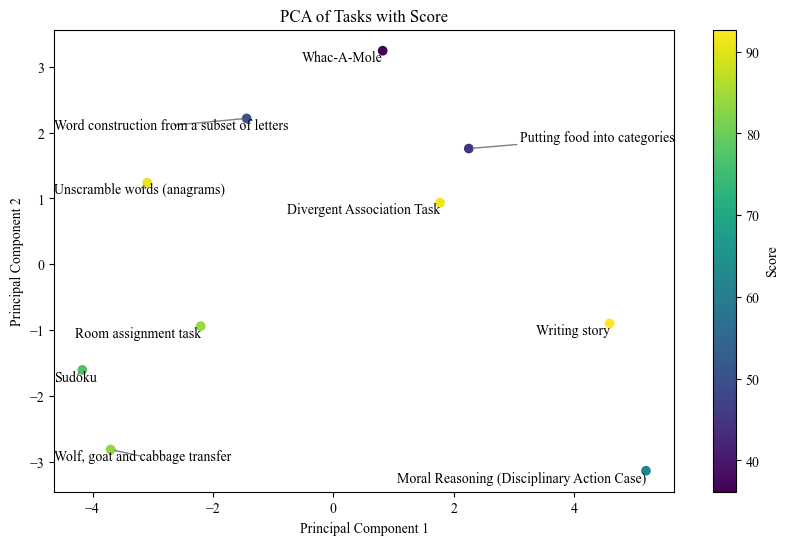

In [95]:
def plot_pca_scatter_with_labels(pca_df, dv, dv_label):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df[dv])

    plt.title("PCA of Tasks with " + dv_label)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    cbar = plt.colorbar(scatter, label=dv_label)

    texts = []
    for i, txt in enumerate(pca_df["task_name"]):
        texts.append(plt.text(pca_df["PC1"].iloc[i], pca_df["PC2"].iloc[i], txt, ha='left'))

    # adjust text labels to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

    # plt.grid(True)

    plt.show()

plot_pca_scatter_with_labels(pca_df, dv = "score", dv_label="Score")

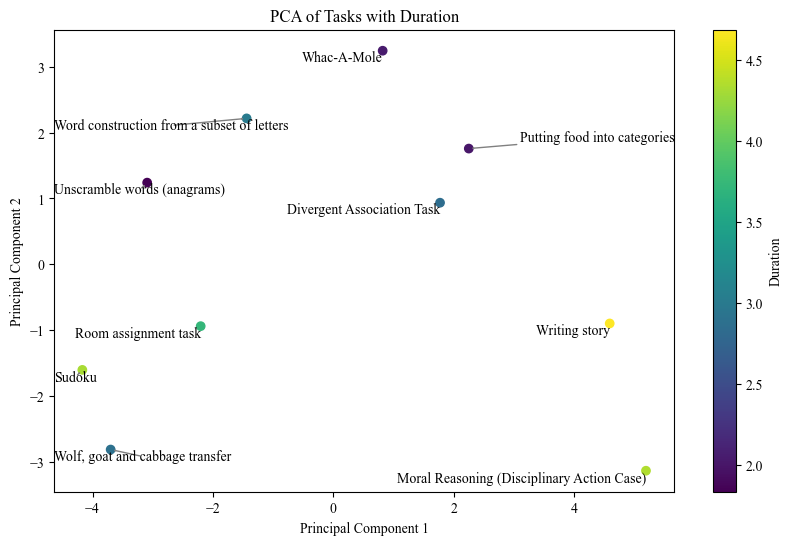

In [96]:
plot_pca_scatter_with_labels(pca_df, dv = "duration", dv_label="Duration")

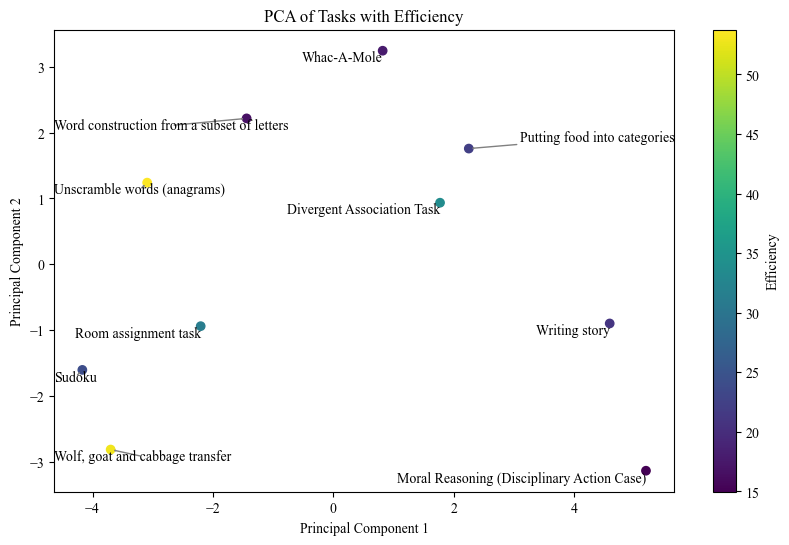

In [97]:
plot_pca_scatter_with_labels(pca_df, dv = "efficiency", dv_label="Efficiency")

# Q^2 Calculation

In [284]:
def reshape_x_y(x, y):
    if(isinstance(x, pd.Series)):
        x = np.asarray(x).reshape(-1, 1)
    else:
        x = np.asarray(x)
    
    y = np.asarray(y).reshape(-1, 1)
    return(x, y)

In [285]:
def q2_task_holdout_helper(x_train, x_test, y_train, y_test, estimator):

    # some reshaping
    x_train_array, y_train_array = reshape_x_y(x_train, y_train)
    x_test_array, y_test_array = reshape_x_y(x_test, y_test)

    # print("Training data: ", pd.DataFrame(x_train_array).head())
    # print("Testing data: ", pd.DataFrame(x_test_array).head())

    # Fit the model and get the error
    fitted_model = estimator.fit(X=x_train_array, y=y_train_array.ravel())
    
    # save prediction error
    prediction = fitted_model.predict(x_test_array)

    # flatten all arrays
    y_test_array = np.asarray(y_test_array).flatten()
    prediction = np.asarray(prediction).flatten()

    # print("y test array", y_test_array)
    # print("prediction", prediction)

    squared_model_prediction_error = (y_test_array - prediction) ** 2

    # save total error for this fold
    squared_average_prediction_error = (y_test_array - np.mean(y_train_array)) ** 2

    return squared_model_prediction_error, squared_average_prediction_error

In [286]:
"""
This is the version of q^2 that holds out EVERYTHING associated with a given task

It trains on all task instances from the "seen" classes, and it tests on task instances of held-out (unseen) classes.

NOTE: this version of the function assumes that x and y are passed in with a column called "task_name"
"""

def get_q2(y, x, estimator = Lasso(), num_task_holdouts = 1):
    squared_model_prediction_errors = []
    squared_average_prediction_errors = []

    num_total_tasks = x["task_name"].nunique()

    # randomly hold out `num_task_holdouts`
    all_possible_task_combos = list(itertools.combinations((x["task_name"].unique()), num_total_tasks - num_task_holdouts))
    
    for sample in all_possible_task_combos:

        # print("Sample:", sample)
        # print("Held out:", x[~x["task_name"].isin(sample)]["task_name"].unique())

        x_train_tasks = x[x["task_name"].isin(sample)].drop("task_name", axis = 1)
        x_test_tasks = x[~x["task_name"].isin(sample)].drop("task_name", axis = 1)

        y_train_tasks = y[y["task_name"].isin(sample)].drop("task_name", axis = 1)
        y_test_tasks = y[~y["task_name"].isin(sample)].drop("task_name", axis = 1)

        # get evaluation score by training on the training tasks and evaluating on the holdout tasks
        squared_model_prediction_error, squared_average_prediction_error = q2_task_holdout_helper(x_train_tasks, x_test_tasks, y_train_tasks, y_test_tasks, estimator)
        
        squared_model_prediction_errors.append(squared_model_prediction_error)
        squared_average_prediction_errors.append(squared_average_prediction_error)

    # Print the evaluation score
    squared_model_prediction_error = np.asarray(squared_model_prediction_error).flatten()
    squared_average_prediction_error = np.asarray(squared_average_prediction_error).flatten()

    # print(squared_model_prediction_error)
    # print(squared_average_prediction_error)

    return 1 - (np.sum(squared_model_prediction_error) / np.sum(squared_average_prediction_error))


In [287]:
# set up prediction
y_score = team_multi_task_data[["score", "task_name"]]
y_duration = team_multi_task_data[["duration", "task_name"]]
y_efficiency = team_multi_task_data[["efficiency", "task_name"]]

x_tasks = team_multi_task_data[list(all_features_and_interactions) + ["task_name"]]

In [288]:
x_tasks_maintaskonly = team_multi_task_data[list(task_cols_to_use) + ["High", "Medium", "task_name"]]
x_tasks_maintaskonly.columns

Index(['Conceptual-Behavioral', 'Type 1 (Planning)', 'Type 2 (Generate)',
       'Type 5 (Cognitive Conflict)', 'Type 7 (Battle)',
       'Type 8 (Performance)', 'Divisible-Unitary', 'Maximizing', 'Optimizing',
       'Outcome Multiplicity', 'Solution Scheme Multiplicity',
       'Decision Verifiability', 'Shared Knowledge', 'Within-System Solution',
       'Answer Recognizability', 'Time Solvability',
       'Type 3 and Type 4 (Objective Correctness)', 'Conflicting Tradeoffs',
       'Solution Scheme Outcome Uncertainty', 'Eureka Question',
       'Intellectual-Manipulative', 'Intellective-Judgmental',
       'Creativity Input', 'High', 'Medium', 'task_name'],
      dtype='object')

In [103]:
get_q2(y_score, x_tasks_maintaskonly, Lasso())

-1.5680800872326546

# Us versus McGrath Q^2 Analysis

In [293]:
mcgrath_colnames = [col for col in task_map.columns if "Type" in col]

In [294]:
# remove type 6, as it is not relevant for our data
mcgrath_colnames.remove('Type 6 (Mixed-Motive)')

In [295]:
mcgrath_colnames

['Type 1 (Planning)',
 'Type 2 (Generate)',
 'Type 5 (Cognitive Conflict)',
 'Type 7 (Battle)',
 'Type 8 (Performance)',
 'Type 3 and Type 4 (Objective Correctness)']

In [296]:
# let's do this for a single mcgrath bucket --- here, assume the max mcgrath one is the bucket!
mcgrath_categorical_buckets = {}

for i in range(len(team_multi_task_data)):
    task_vec_mcgrath = team_multi_task_data[mcgrath_colnames].iloc[i][1:]
    task_name = team_multi_task_data.iloc[i]["task_name"]
    task_type = task_vec_mcgrath.idxmax()
    type_val = task_vec_mcgrath[task_type]
    if task_type == "Type 3 and Type 4 (Objective Correctness)":
        task_type = "Type 3 (Intellective)" if type_val > 0.5 else "Type 4 (Decision-Making)"

    mcgrath_categorical_buckets[task_name] = task_type

In [297]:
mcgrath_categorical_buckets ### TODO -- manually adjust these

{'Unscramble words (anagrams)': 'Type 3 (Intellective)',
 'Writing story': 'Type 5 (Cognitive Conflict)',
 'Moral Reasoning (Disciplinary Action Case)': 'Type 5 (Cognitive Conflict)',
 'Word construction from a subset of letters': 'Type 2 (Generate)',
 'Room assignment task': 'Type 3 (Intellective)',
 'Whac-A-Mole': 'Type 7 (Battle)',
 'Putting food into categories': 'Type 2 (Generate)',
 'Sudoku': 'Type 8 (Performance)',
 'Divergent Association Task': 'Type 2 (Generate)',
 'Wolf, goat and cabbage transfer': 'Type 8 (Performance)'}

In [303]:
mcgrath_df = pd.DataFrame({
    "task_name": mcgrath_categorical_buckets.keys(),
    "mcgrath_category": mcgrath_categorical_buckets.values()
})

mcgrath_df_categorical = pd.concat([mcgrath_df["task_name"], pd.get_dummies(mcgrath_df["mcgrath_category"], dtype= int).add_suffix('_cat')], axis = 1)

In [310]:
mcgrath_categorical = list(mcgrath_df_categorical.columns)
mcgrath_categorical.remove("task_name")

In [314]:
team_multi_task_data = team_multi_task_data.merge(mcgrath_df_categorical, on = "task_name")

In [319]:
dv_output_dict_comparison = {}
for dv in ["score"]:
    dv_output_dict_comparison[dv] = {}
    dv_output_dict_comparison[dv]["mcgrath_continuous"] = get_q2(team_multi_task_data[[dv, "task_name"]], team_multi_task_data[mcgrath_colnames + ["playerCount", "Low", "Medium", "task_name"]])
    dv_output_dict_comparison[dv]["mcgrath_categorical"] = get_q2(team_multi_task_data[[dv, "task_name"]], team_multi_task_data[mcgrath_categorical + ["playerCount", "Low", "Medium", "task_name"]])
    dv_output_dict_comparison[dv]["lasso_selected_features"] = get_q2(team_multi_task_data[[dv, "task_name"]], team_multi_task_data[list(nonzero_lasso_weights_task) + ["playerCount", "Low", "Medium", "task_name"]])
    dv_output_dict_comparison[dv]["all_features"] = get_q2(team_multi_task_data[[dv, "task_name"]], team_multi_task_data[list(task_cols_to_use) + ["playerCount", "Low", "Medium", "task_name"]])

In [322]:
mcgrath_colnames

['Type 1 (Planning)',
 'Type 2 (Generate)',
 'Type 5 (Cognitive Conflict)',
 'Type 7 (Battle)',
 'Type 8 (Performance)',
 'Type 3 and Type 4 (Objective Correctness)']

In [323]:
mcgrath_categorical

['Type 2 (Generate)_cat',
 'Type 3 (Intellective)_cat',
 'Type 5 (Cognitive Conflict)_cat',
 'Type 7 (Battle)_cat',
 'Type 8 (Performance)_cat']

In [324]:
list(nonzero_lasso_weights_task)

['Type 2 (Generate)',
 'Type 7 (Battle)',
 'Type 8 (Performance)',
 'Maximizing',
 'Optimizing',
 'Conflicting Tradeoffs',
 'Solution Scheme Outcome Uncertainty',
 'Eureka Question',
 'Intellective-Judgmental']

In [320]:
dv_output_dict_comparison

{'score': {'mcgrath_continuous': 0.21129678069399715,
  'mcgrath_categorical': 0.41170173155700285,
  'lasso_selected_features': -0.40266668960319496,
  'all_features': -1.5676989330184825}}

## Train on 9 tasks, Test on 1 task: Predicting DV's Based on Task Attributes

Starting with a vanilla version with no hyperparameter optimization

In [83]:
# lassocv = LassoCV(cv=10, random_state=0, max_iter=100000).fit(team_multi_task_data[list(task_cols_to_use)], team_multi_task_data["score"])
# best_alpha = lassocv.alpha_

In [105]:
get_q2(y_score, x_tasks, estimator = RandomForestRegressor())

-1.5376128229560866

In [106]:
get_q2(y_duration, x_tasks, estimator = RandomForestRegressor())

-0.29794405279328573

In [107]:
get_q2(y_efficiency, x_tasks, estimator = RandomForestRegressor())

0.07224574989457078

In [108]:
# plot a histogram of an array
def plot_q2_hist(q2_arr):
    plt.hist(q2_arr, bins=10, edgecolor='black')
    plt.axvline(np.mean(q2_arr), color='red', linestyle='dashed', linewidth=2)
    plt.xlabel('Q^2')
    plt.ylabel('Frequency')
    plt.show()

## Adding hyperparameter optimization

In [120]:
# code adapted from Mohammed's q2 optimization notebook
model_dict = {
                # "RandomForestRegressor":{"model":RandomForestRegressor,
				# 	"params":[{"name":"n_estimators", "type":"range", "bounds":[2,200]},
				# 			{"name":"max_depth", "type":"range", "bounds":[1,5]},
				# 			{"name":"min_samples_leaf", "type":"range", "bounds":[1,5]}]},
            #     "MLPRegressor":{"model": MLPRegressor,
			# 		"params":[{"name":"activation", "type":"choice", "values":["identity", "logistic", "tanh", "relu"]},
			# 				{"name":"solver", "type":"choice", "values":["sgd", "adam"]},
            #                 {"name": "alpha", "type": "range", "bounds":[0.0001,1.0]},
            #                 {"name":"learning_rate", "type":"choice", "values":["constant", "adaptive"]},
            #                 {"name":"learning_rate_init", "type":"range", "bounds":[0.0001, 0.01]},
            #                 {"name":"max_iter", "type":"range", "bounds":[350, 650]}
            #             ]},
			#    "ElasticNet":{ "model": ElasticNet,
			# 		"params":[{"name": "alpha", "type": "range", "bounds":[0.001,1.0]},
			# 				{"name": "l1_ratio", "type": "range", "bounds":[0.0,1.0]},
			# 				{"name": "max_iter", "type": "range", "bounds":[200, 2000]},
			# 				{"name": "selection", "type": "choice", "values":["cyclic", "random"]}
			# 			]},
                "Lasso": { "model": Lasso,
                    "params":[{"name": "alpha", "type": "range", "bounds":[0.000000001,1.0]},
                            {"name": "max_iter", "type": "range", "bounds":[100000, 300000]}]   
                }
			}

def get_optimal_model(y, X, model_type, total_trials):
    best_parameters, best_values, experiment, model = optimize(
        parameters= model_dict[model_type]["params"],
        evaluation_function=lambda p: get_q2(y, X, model_dict[model_type]["model"](**p)),
        minimize=False,
        total_trials=total_trials,
    )
    optimal_parameters = best_parameters 
    optimization_q2 = best_values[0]["objective"]

    return(optimal_parameters, optimization_q2)

In [121]:
optimal_dict = {
    "dv": [],
    "optimal_q2": [],
    "optimal_params": [],
    "model_type": []
}

In [122]:
dvs = ["score"]

for model_type in model_dict.keys():
    for dv in dvs:
        # set up x and y
        y_dv = team_multi_task_data[[dv, "task_name"]]
        x_tasks = team_multi_task_data[list(task_cols_to_use) + ["task_name"]]
        # x_tasks = team_multi_task_data[all_features_and_interactions + ["task_name"]]

        optimal_params, optimal_q2 = get_optimal_model(y_dv, x_tasks, model_type = model_type, total_trials = 30)
        optimal_dict["dv"].append(dv)
        optimal_dict["optimal_q2"].append(optimal_q2)
        optimal_dict["optimal_params"].append(optimal_params)
        optimal_dict["model_type"].append(model_type)

[INFO 05-16 20:24:58] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter alpha. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-16 20:24:58] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_iter. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-16 20:24:58] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='alpha', parameter_type=FLOAT, range=[1e-09, 1.0]), RangeParameter(name='max_iter', parameter_type=INT, range=[100000, 300000])], parameter_constraints=[]).
[INFO 05-16 20:24:58] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 05-16 20:24:58] ax.model

In [105]:
# # save the optimal_dict in the future
# with open('./task_map_explorations_with_multitask/optimal_dict_task_class_with_3_wave_multi_task_data_50_trials.pkl', 'wb') as pkl_file:
#     pickle.dump(optimal_dict, pkl_file)

In [92]:
# # read dict from pkl so that we don't have to run the Ax again
# with open('./task_map_explorations_with_multitask/lasso_optimal_task_class_with_3_wave_multi_task_data_50_trials.pkl', 'rb') as pkl_file:
#     optimal_dict = pickle.load(pkl_file)

In [127]:
pd.DataFrame(optimal_dict)

,dv,optimal_q2,optimal_params,model_type
0,score,-0.171345,"{'alpha': 1e-09, 'max_iter': 100000}",Lasso


In [128]:
# do we do any better after optimization?
best_lasso_estimator = Lasso(
        alpha = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("Lasso")]["alpha"],
        max_iter = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("Lasso")]["max_iter"],
    )
get_q2(y_score, x_tasks, estimator = best_lasso_estimator)

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.385e+05, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e+05, tolerance: 1.611e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.594e+04, toleranc

-0.17134515487773738

## Q^2 by Number of Features

In [129]:
# q^2 for univariate features
q_2_for_all_dvs_task = []
dvs = ["score"]    
for dv in dvs:
    within_dv_arr = []
    for col in task_cols_to_use:
        # get the q2 for each
        y_dv = team_multi_task_data[[dv, "task_name"]]
        x_tasks = team_multi_task_data[[col] + ["task_name"]]
        q2 = get_q2(y_dv, x_tasks)

        within_dv_arr.append(q2)

    q_2_for_all_dvs_task.append(within_dv_arr)

In [130]:
# turn this into a dataframe
q2_by_dv_df_task = pd.DataFrame(q_2_for_all_dvs_task, columns=task_cols_to_use, index = dvs)
# sort by average
q2_by_dv_df_task = q2_by_dv_df_task.reindex(q2_by_dv_df_task.mean().sort_values(ascending=False).index, axis=1)

In [131]:
q2_by_dv_df_task

,Outcome Multiplicity,Optimizing,Time Solvability,Conceptual-Behavioral,Type 3 and Type 4 (Objective Correctness),Decision Verifiability,Answer Recognizability,Type 7 (Battle),Type 2 (Generate),Within-System Solution,...,Solution Scheme Multiplicity,Eureka Question,Type 5 (Cognitive Conflict),Intellectual-Manipulative,Conflicting Tradeoffs,Type 8 (Performance),Creativity Input,Type 1 (Planning),Maximizing,Divisible-Unitary
score,0.425422,0.301236,0.248414,0.231255,0.149596,0.143016,0.137896,0.08598,0.05274,0.023256,...,-0.002212,-0.016048,-0.03332,-0.073911,-0.086621,-0.131664,-0.22356,-0.31866,-0.981546,-2.565362


In [132]:
# get top univariate features
def top_n_q2_for_index(index, n):
    q2_by_dv_df = q2_by_dv_df_task
    top_columns = q2_by_dv_df.loc[index].nlargest(n).index.tolist()
    return top_columns

In [133]:
def get_q2_improvement_with_number_of_tasks(estimator, feature_list, dvs = ["score"], optimize_each_step = False, model_type = None):   
    dv_output_dict_best = {}

    for i, dv in enumerate(dvs):
        dv_output_dict_best[dv] = []

        for num_features in range(1, len(feature_list)+1):
            print("Now running models for " + str(num_features) + " features...")
            
            # select the best model by choosing the top features in terms of univariate q^2
            top_features_class = top_n_q2_for_index(dv, num_features)
            y_dv = team_multi_task_data[[dv, "task_name"]]
            x_tasks = team_multi_task_data[top_features_class + ["task_name"]]

            if(optimize_each_step): # optimize a model with hyperparameters for THIS set of features
                optimal_params, optimal_q2 = get_optimal_model(y_dv, x_tasks, model_type = model_type, total_trials = 10)
                print("Found optimal model with Q^2 of " + str(optimal_q2))
                estimator = model_dict[model_type]["model"](**optimal_params)
            
            q2_class = get_q2(y_dv, x_tasks, estimator=estimator) 
            dv_output_dict_best[dv].append(q2_class)
    
    return dv_output_dict_best

In [136]:
# MLPRegressor
# best_estimator = MLPRegressor(
#     alpha = optimal_dict["optimal_params"][i]["alpha"],
#     learning_rate_init = optimal_dict["optimal_params"][i]["learning_rate_init"],
#     max_iter = optimal_dict["optimal_params"][i]["max_iter"],
#     activation = optimal_dict["optimal_params"][i]["activation"],
#     solver = optimal_dict["optimal_params"][i]["solver"],
#     learning_rate = optimal_dict["optimal_params"][i]["learning_rate"]
# )

for dv in ["score"]:#, "duration", "efficiency"]:

    # best_estimator = ElasticNet(
    #     alpha = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("ElasticNet")]["alpha"],
    #     l1_ratio = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("ElasticNet")]["l1_ratio"],
    #     max_iter = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("ElasticNet")]["max_iter"],
    #     selection = optimal_dict["optimal_params"][list(optimal_dict["model_type"]).index("ElasticNet")]["selection"]
    # )

    dv_output_dict_best = get_q2_improvement_with_number_of_tasks(estimator = best_lasso_estimator, feature_list = task_cols_to_use)

Now running models for 1 features...
Now running models for 2 features...
Now running models for 3 features...
Now running models for 4 features...
Now running models for 5 features...
Now running models for 6 features...
Now running models for 7 features...


Now running models for 8 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.517e+05, tolerance: 1.580e+02



Now running models for 9 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.346e+05, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.383e+05, tolerance: 1.606e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.235e+03, toleranc

Now running models for 10 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.387e+04, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.285e+04, tolerance: 1.611e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.649e+04, toleranc

Now running models for 11 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.336e+04, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.191e+05, tolerance: 1.611e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e+05, toleranc

Now running models for 12 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.209e+05, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.556e+04, tolerance: 1.611e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.535e+04, toleranc

Now running models for 13 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e+05, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.251e+04, tolerance: 1.611e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.723e+04, toleranc

Now running models for 14 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.395e+05, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.133e+05, tolerance: 1.611e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.212e+04, toleranc

Now running models for 15 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e+05, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.667e+03, tolerance: 1.611e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.186e+05, toleranc

Now running models for 16 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.918e+05, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.565e+04, tolerance: 1.611e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.257e+04, toleranc

Now running models for 17 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e+05, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.009e+05, tolerance: 1.611e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.714e+04, toleranc

Now running models for 18 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.168e+05, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e+05, tolerance: 1.611e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.912e+04, toleranc

Now running models for 19 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.289e+05, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.329e+05, tolerance: 1.611e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.050e+04, toleranc

Now running models for 20 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.784e+05, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.138e+04, tolerance: 1.611e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.138e+04, toleranc

Now running models for 21 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.002e+05, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.402e+04, tolerance: 1.611e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.458e+04, toleranc

Now running models for 22 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.507e+05, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.534e+04, tolerance: 1.611e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.733e+04, toleranc

Now running models for 23 features...


/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.429e+05, tolerance: 1.436e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.422e+04, tolerance: 1.611e+02

/Users/xehu/anaconda3/envs/tpm_horserace/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.127e+05, toleranc

### Line Plot as Number of Features Increases

In [138]:
def plot_q2_by_number_of_features(df_q2_means_for_feature, feature_list, title):
    fig, ax = plt.subplots(layout='constrained', figsize=(24, 5))

    # Store colors for each DV
    dv_colors = {}

    width = 0.16  # the width of the bars
    multiplier = 0

    for dv in df_q2_means_for_feature.columns:
        means_for_key = df_q2_means_for_feature[dv]
        # stds_for_key = df_q2_stds_for_feature[dv]
        # offset = width * multiplier
        # offset_back = (0.16) * 2.5
        # line plot version
        line, = ax.plot(np.arange(1, len(feature_list)+1), means_for_key, label=f'{dv}')
        dv_colors[dv] = line.get_color()  # Store the color for this DV

        # bar plot version
        # rects = ax.bar(np.arange(1, len(feature_list)+1) + offset - offset_back, means_for_key, width, label=f'{dv}')
        for i in range(1, len(feature_list)+1):
            x = i # + offset - offset_back
            y = means_for_key[i-1]
            # std = stds_for_key[i-1]
            # ax.errorbar(x, y, std, color="black")
        multiplier += 1

    # Adding horizontal gray line at y=0
    ax.axhline(0, color='gray', linestyle='--', linewidth=1.5)

    # Add horizontal lines for "optimal" model performance for each DV
    # TODO --- this needs to be adjusted based on the optimality of task class LOO versus task instance LOO
    # for dv in df_q2_means_for_feature.columns:
    #     optimal_df = pd.DataFrame(optimal_dict)
    #     performance_for_dv = optimal_df[optimal_df["dv"] == dv]
    #     best_perf = np.max(performance_for_dv["optimal_q2"])
    #     ax.axhline(best_perf, color=dv_colors[dv], linestyle='--', linewidth=1.5)

    # ax.set_ylim(-4, 4)
    ax.legend(fontsize=14, loc='lower right')
    plt.xticks(ticks=[_ for _ in range(1, len(feature_list)+1)], fontsize=24)
    plt.yticks(fontsize=24)

    plt.xlabel('Number of Task Features Included', fontsize=24)
    plt.ylabel('Q^2', fontsize=24)

    plt.title(title, fontsize = 24)

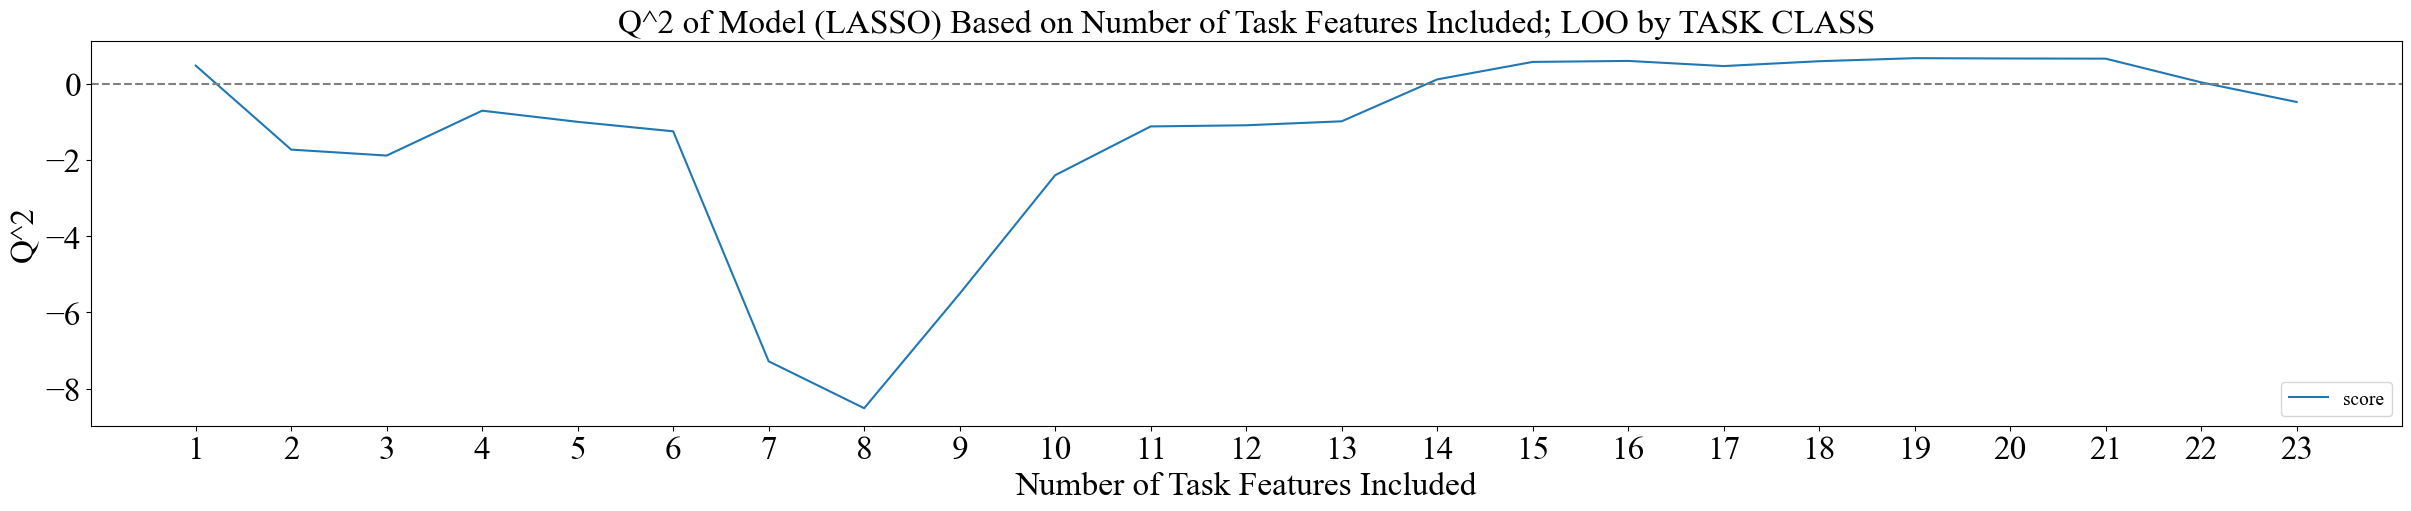

In [143]:
df_q2_means_for_feature = pd.DataFrame()
for key in dv_output_dict_best.keys():
    means = [np.mean(sublist) for sublist in dv_output_dict_best[key]]
    df_q2_means_for_feature[key] = means

plot_q2_by_number_of_features(df_q2_means_for_feature, feature_list = task_cols_to_use, title = 'Q^2 of Model (LASSO) Based on Number of Task Features Included; LOO by TASK CLASS')

In [140]:
tasks_unique = team_multi_task_data["task_name"].unique()

In [ ]:
dvs = ["score"]
q2_by_task_output_dict = {}

for dv in dvs:
    q2_by_task_output_dict[dv] = {}

    for num_tasks in range(1, len(tasks_unique)):
        print("Now running models for " + str(num_tasks) + " tasks...")
        q2_by_task_output_dict[dv][str(num_tasks)] = []

        ### For holding out a FULL TASK
        y_dv = team_multi_task_data[[dv, "task_name"]]
        # x_tasks = team_multi_task_data[all_features_and_interactions + ["task_name"]] # all task features and interactions
        x_tasks = team_multi_task_data[list(task_cols_to_use) + ["task_name"]] # only task features
        q2 = get_q2(y_dv, x_tasks, num_task_holdouts=len(tasks_unique)-num_tasks, estimator = best_lasso_estimator)
        q2_by_task_output_dict[dv][str(num_tasks)].append(q2)

In [ ]:
df_q2_means_for_task = pd.DataFrame()
for key in q2_by_task_output_dict.keys():
    means = [np.mean(sublist) for sublist in q2_by_task_output_dict[key].values()]
    df_q2_means_for_task[key] = means
df_q2_means_for_task

,score
0,0.000000
1,-0.847594
2,0.065779
3,0.305585
4,-0.011591
5,-0.323387
6,-0.467323
7,0.103309
8,0.385345


Text(0.5, 1.0, 'Q^2 by Number of Tasks In Training Set -- Using Optimized LASSO (On Task Features ONLY) to Predict on Held Out Task(s)')

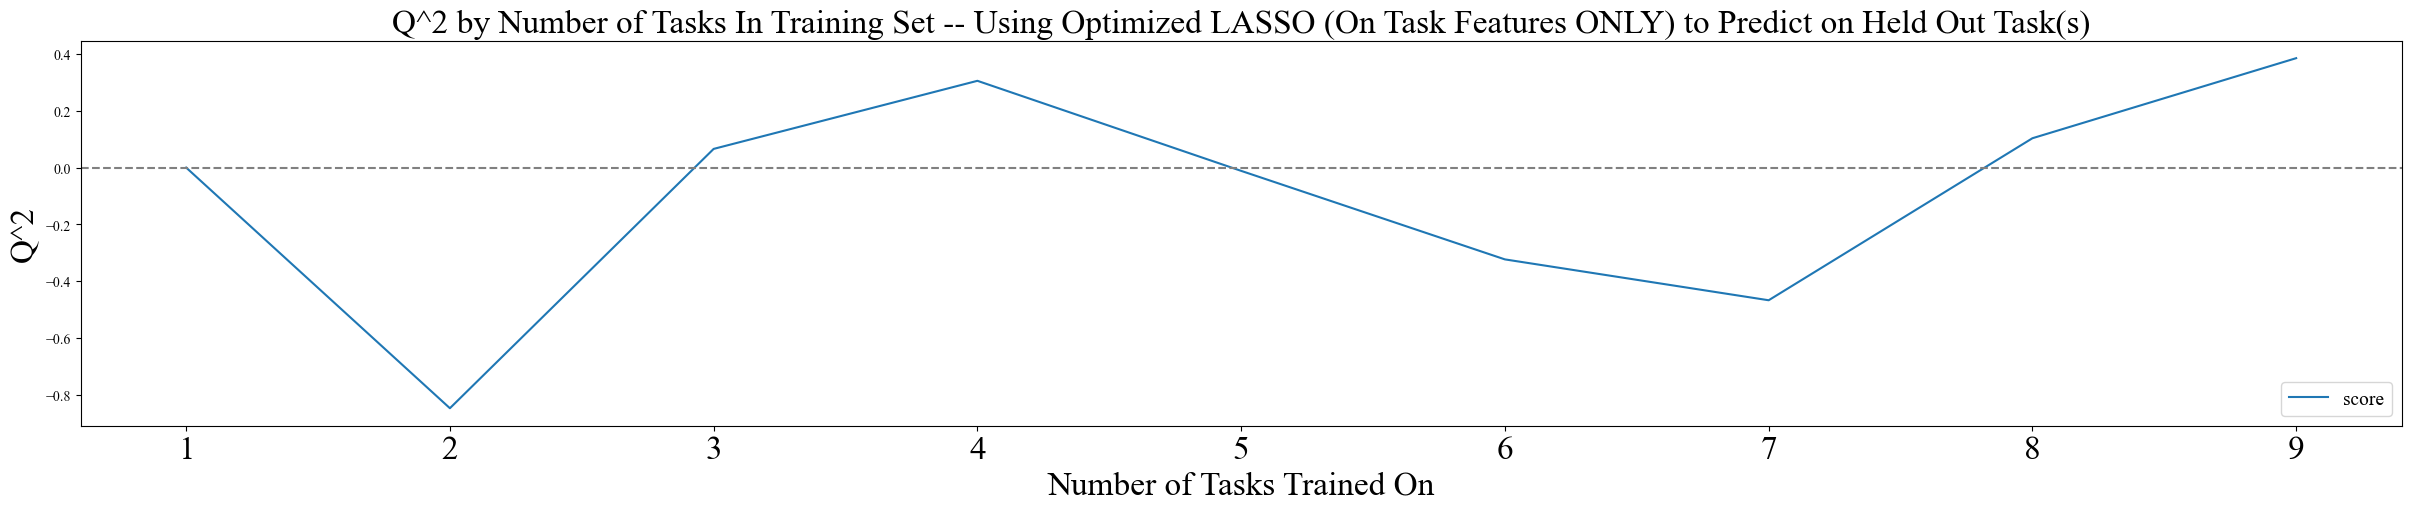

In [ ]:
fig, ax = plt.subplots(layout='constrained', figsize=(24, 5))

width = 0.16  # the width of the bars
multiplier = 0

dv_colors = {}

for dv in df_q2_means_for_task.columns:
    means_for_key = df_q2_means_for_task[dv]
    # stds_for_key = df_q2_stds_for_task[dv]
    # line plot version
    line, = ax.plot(np.arange(1, len(tasks_unique)), means_for_key, label=f'{dv}')
    dv_colors[dv] = line.get_color()  # Store the color for this DV
    # bar plot version
    # rects = ax.bar(np.arange(1, len(tasks_unique)) + offset - offset_back, means_for_key, width, label=f'{dv}')
    # for i in range(1, len(tasks_unique)):
    #     x = i
    #     y = means_for_key[i-1]
    #     # std = stds_for_key[i-1]
    #     ax.errorbar(x, y, std, color="black")
    # multiplier += 1

ax.legend(fontsize=14, loc='lower right')
plt.xticks(ticks=[_ for _ in range(1, len(tasks_unique))], fontsize=24)
plt.xlabel('Number of Tasks Trained On', fontsize=24)

# yticks = np.arange(ax.get_ylim()[0], ax.get_ylim()[1] + 0.1, 0.1)
# yticks = np.unique(np.concatenate((yticks, np.round(yticks))))
# yticklabels = [f'{round(tick, 1)}' if round(tick, 1) == tick else '' for tick in yticks]
# plt.yticks(yticks, yticklabels, fontsize=24)

# Adding horizontal gray line at y=0
ax.axhline(0, color='gray', linestyle='--', linewidth=1.5)

# Adding lines for optimal performance
# TODO --- this needs to be redone based on the task class holdout scheme
# for dv in df_q2_means_for_feature.columns:
#     optimal_df = pd.DataFrame(optimal_dict)
#     performance_for_dv = optimal_df[optimal_df["dv"] == dv]
#     best_perf = np.max(performance_for_dv["optimal_q2"])
#     ax.axhline(best_perf, color=dv_colors[dv], linestyle='--', linewidth=1.5)

plt.ylabel('Q^2', fontsize=24)

plt.title('Q^2 by Number of Tasks In Training Set -- Using Optimized LASSO (On Task Features ONLY) to Predict on Held Out Task(s)', fontsize=24)

# [Backlog] Q^2 at the Instance Level

In [107]:
# This does q2 at the *task instance level*
def q2_baseline_models(y, X, estimator):
    baseline_models = []
    for loo_index in range(len(y)):
        if hasattr(estimator, "random_state"):
            estimator.random_state = loo_index

        x_train, y_train = reshape_x_y(X.drop(loo_index), y.drop(loo_index))
        baseline_models.append(deepcopy(estimator.fit(X=x_train, y=y_train.ravel())))
        
    return baseline_models

def get_q2_task_instance(y, X, estimator=LinearRegression()):
    models = q2_baseline_models(y, X, estimator)
    q2_means = []
    q2_preds = []
    
    for loo_index in range(len(y)):
        q2_means.append(y.drop(loo_index).mean())
        q2_preds.append(models[loo_index].predict(np.array(X.iloc[loo_index]).reshape(1,-1)))

    # fix dimensions
    q2_means = np.array(q2_means)
    q2_preds = np.array(q2_preds).flatten()

    q2 = 1 - np.sum((q2_preds - np.array(y).flatten())**2) / np.sum((q2_means - np.array(y).flatten())**2)
    
    return q2